## tuning regularization parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import wobble

/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
starname = '51peg'
r = 57

In [3]:
data = wobble.Data(starname+'_e2ds.hdf5', filepath='data/', orders=[r])
model = wobble.Model(data)
model.add_star(starname)
model.add_telluric('tellurics', rvs_fixed=True, variable_bases=0)

In [4]:
model.components[0].L1_template = 1.e4 # star
model.components[0].L2_template = 1.e2   # star
model.components[1].L1_template = 1.e4 # tellurics
model.components[1].L2_template = 1.e2   # tellurics

In [5]:
wobble.optimize_order(model, data, 0, 
                niter=50, save_history=True, basename=starname) 
history = wobble.History(model, data, 0, 50, filename=starname+'_o0_history.hdf5')

100%|██████████| 50/50 [00:12<00:00,  4.04it/s]


saving optimization history to 51peg_o0_history.hdf5


In [6]:
#from IPython.display import HTML
#ani = history.plot_template(0,model,data)
#HTML(ani.to_html5_video())

In [7]:
session = wobble.get_session()
star_ys = session.run(model.components[0].shift_and_interp(0, data.xs[0], model.components[0].rvs_block[0]))
t_xs = session.run(model.components[1].template_xs[0])
t_ys = session.run(model.components[1].template_ys[0])
data_xs = session.run(data.xs[0])
data_ys = session.run(data.ys[0])
rvs_star = session.run(model.components[0].rvs_block[0])

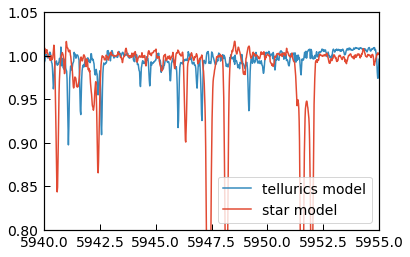

In [8]:
epoch = 12
plt.plot(np.exp(t_xs), np.exp(t_ys), label='tellurics model', lw=1.5)
plt.plot(np.exp(data_xs[epoch]), np.exp(star_ys[epoch]), label='star model', lw=1.5)
plt.legend(loc='lower right', fontsize=14)
plt.ylim([0.8,1.05])
plt.xlim([5940, 5955])
plt.savefig('reg_L1s{0:.0e}_L2s{1:.0e}_L1t{2:.0e}_L2t{3:.0e}.png'.format(
    model.components[0].L1_template, model.components[0].L2_template,
    model.components[1].L1_template, model.components[1].L2_template));

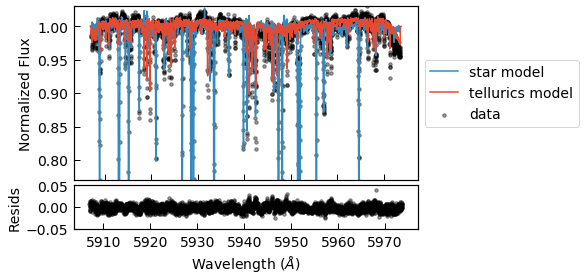

In [9]:
fig, (ax, ax2) = plt.subplots(2, 1, gridspec_kw = {'height_ratios':[4, 1]})
ax.plot(np.exp(data_xs[epoch]), np.exp(star_ys[epoch]), label='star model', lw=1.5)
ax.plot(np.exp(t_xs), np.exp(t_ys), label='tellurics model', lw=1.5)
ax.scatter(np.exp(data_xs[epoch]), np.exp(data_ys[epoch]), marker=".", alpha=0.4, c='k', label='data')
#ax.set_xlim([5940, 5945])
ax.set_ylim([0.77, 1.03])
ax.set_xticklabels([])
ax.set_ylabel('Normalized Flux', fontsize=14)
resids = np.exp(data_ys[epoch]) - np.exp(session.run(model.synthesize(0))[epoch])
ax2.scatter(np.exp(data_xs[epoch]), resids, marker=".", alpha=0.4, c='k')
#ax2.set_xlim([5940, 5945])
ax2.set_ylim([-0.05, 0.05])
ax2.set_xlabel(r'Wavelength ($\AA$)', fontsize=14)
ax2.set_ylabel('Resids', fontsize=14)

# Shrink current axis by 50%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.5, box.height])

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)
fig.tight_layout()
fig.subplots_adjust(hspace=0.05)